In [1]:
import sys
sys.path.append('../../src')

from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

from imblearn.over_sampling import ADASYN, SMOTE

import visualization.visualize as vis
import models.evaluation as ev

In [2]:
filename = '../../data/raw/Myocardial infarction complications Database.csv'
data = pd.read_csv(filename)
data

,ID,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,IBS_NASL,GB,SIM_GIPERT,...,JELUD_TAH,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS
0,1,77.0,1,2.0,1.0,1.0,2.0,NaN,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2,55.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,3,52.0,1,0.0,0.0,0.0,2.0,NaN,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,4,68.0,0,0.0,0.0,0.0,2.0,NaN,2.0,0.0,...,0,0,0,0,0,0,1,0,0,0
4,5,60.0,1,0.0,0.0,0.0,2.0,NaN,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,1696,77.0,0,0.0,4.0,2.0,1.0,NaN,2.0,0.0,...,0,0,1,0,1,0,0,0,0,3
1696,1697,70.0,0,0.0,6.0,2.0,1.0,NaN,2.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1697,1698,55.0,1,3.0,6.0,2.0,2.0,NaN,0.0,0.0,...,0,0,0,0,0,0,0,1,0,6
1698,1699,79.0,0,2.0,2.0,2.0,1.0,NaN,2.0,0.0,...,0,0,0,1,0,0,0,0,0,1


# Data Preparation

In [3]:
ID_COLS = ['ID']
TARGET_COLS = ['FIBR_PREDS', 'PREDS_TAH', 'JELUD_TAH', 'FIBR_JELUD', 'A_V_BLOK',
               'OTEK_LANC', 'RAZRIV', 'DRESSLER', 'ZSN', 'REC_IM', 'P_IM_STEN', 'LET_IS']
TARGET_COL = 'LET_IS'

In [4]:
data_train, data_test = train_test_split(data, test_size=0.3, random_state=42)

print('data_train:', data_train.shape)
print('data_test:', data_test.shape)

data_train: (1190, 124)
data_test: (510, 124)


In [5]:
data_train[TARGET_COL].value_counts(dropna=False)

0    1003
1      76
3      38
6      20
7      16
2      15
4      14
5       8
Name: LET_IS, dtype: int64

In [6]:
data_test[TARGET_COL].value_counts(dropna=False)

0    426
1     34
3     16
7     11
4      9
6      7
5      4
2      3
Name: LET_IS, dtype: int64

In [7]:
data_train = data_train[data_train[TARGET_COL] > 0]
data_test = data_test[data_test[TARGET_COL] > 0]

In [8]:
data_train[TARGET_COL].value_counts(dropna=False)

1    76
3    38
6    20
7    16
2    15
4    14
5     8
Name: LET_IS, dtype: int64

In [9]:
data_test[TARGET_COL].value_counts(dropna=False)

1    34
3    16
7    11
4     9
6     7
5     4
2     3
Name: LET_IS, dtype: int64

In [10]:
TARGET_NAMES = list(set(data_train[TARGET_COL]))
TARGET_DICT = {name:i for i,name in enumerate(TARGET_NAMES)}
TARGET_DICT

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}

In [11]:
def data_preparation(x_df, y_cols, target_col):
    x_array = x_df.drop(columns=y_cols)
    y_true = x_df[target_col].values
    return x_array, y_true

x_train, y_train = data_preparation(data_train, TARGET_COLS+ID_COLS, TARGET_COL)
x_test, y_test = data_preparation(data_test, TARGET_COLS+ID_COLS, TARGET_COL)

In [12]:
x_train

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,IBS_NASL,GB,SIM_GIPERT,DLIT_AG,...,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n
1609,65.0,1,0.0,1.0,2.0,1.0,NaN,2.0,0.0,NaN,...,0.0,0.0,NaN,0.0,0.0,1.0,1.0,1.0,0.0,0.0
1678,63.0,1,0.0,0.0,0.0,0.0,NaN,2.0,0.0,7.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
1447,76.0,1,0.0,6.0,3.0,2.0,NaN,3.0,0.0,7.0,...,3.0,NaN,NaN,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1519,67.0,1,0.0,1.0,2.0,2.0,NaN,3.0,0.0,2.0,...,0.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1549,66.0,0,0.0,6.0,3.0,NaN,NaN,2.0,0.0,3.0,...,1.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1437,65.0,1,3.0,5.0,2.0,2.0,NaN,3.0,0.0,NaN,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
1515,63.0,1,1.0,6.0,2.0,2.0,NaN,2.0,0.0,NaN,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
1482,72.0,1,1.0,1.0,2.0,1.0,NaN,2.0,0.0,7.0,...,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1638,63.0,0,3.0,2.0,2.0,1.0,NaN,2.0,0.0,NaN,...,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
y_train = np.array([TARGET_DICT[y] for y in y_train])
y_train

array([2, 2, 0, 5, 4, 0, 0, 2, 1, 2, 2, 2, 3, 2, 3, 0, 4, 0, 0, 0, 0, 0,
       0, 0, 5, 2, 2, 0, 3, 0, 6, 0, 2, 2, 2, 6, 0, 0, 2, 6, 1, 0, 3, 3,
       0, 0, 0, 2, 2, 5, 0, 1, 1, 1, 2, 2, 0, 0, 2, 6, 3, 1, 0, 4, 0, 0,
       1, 0, 2, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 2, 0, 2, 1, 0, 0, 6,
       5, 5, 3, 6, 6, 6, 0, 3, 4, 3, 5, 0, 0, 5, 0, 2, 0, 0, 2, 0, 0, 5,
       5, 2, 0, 0, 6, 0, 5, 2, 0, 0, 5, 4, 5, 0, 0, 5, 0, 4, 2, 0, 2, 0,
       0, 6, 2, 0, 1, 2, 2, 3, 3, 0, 1, 0, 0, 6, 0, 1, 2, 4, 5, 1, 0, 5,
       5, 2, 0, 5, 2, 0, 4, 0, 6, 0, 2, 0, 0, 3, 2, 0, 6, 0, 0, 5, 2, 1,
       0, 6, 2, 2, 6, 5, 1, 0, 0, 0, 3])

In [14]:
x_test

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,IBS_NASL,GB,SIM_GIPERT,DLIT_AG,...,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n
1492,67.0,0,1.0,0.0,0.0,2.0,NaN,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1645,72.0,0,1.0,NaN,NaN,NaN,NaN,2.0,0.0,NaN,...,0.0,0.0,NaN,1.0,0.0,1.0,1.0,0.0,0.0,0.0
1431,74.0,1,1.0,3.0,2.0,2.0,NaN,0.0,0.0,0.0,...,1.0,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1588,72.0,0,2.0,3.0,2.0,1.0,NaN,2.0,0.0,6.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1529,67.0,1,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,77.0,1,3.0,6.0,2.0,1.0,NaN,3.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1526,63.0,1,0.0,5.0,2.0,2.0,NaN,2.0,0.0,6.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
1686,85.0,1,1.0,0.0,0.0,0.0,NaN,3.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1631,58.0,1,3.0,6.0,2.0,2.0,NaN,2.0,0.0,7.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


In [15]:
y_test = np.array([TARGET_DICT[y] for y in y_test])
y_test

array([3, 0, 0, 3, 3, 3, 0, 0, 2, 0, 2, 5, 0, 4, 0, 2, 2, 2, 0, 0, 0, 2,
       3, 1, 0, 0, 6, 0, 0, 0, 5, 2, 4, 3, 6, 0, 2, 6, 3, 0, 3, 0, 0, 2,
       2, 0, 0, 5, 0, 0, 6, 2, 0, 0, 2, 6, 3, 4, 5, 2, 0, 0, 0, 6, 0, 1,
       2, 6, 5, 1, 5, 0, 6, 2, 0, 6, 6, 2, 6, 4, 0, 5, 0, 0])

# Pre-processing

In [16]:
feature_cols = np.array(x_train.columns[~np.isin(x_train.columns, ID_COLS+TARGET_COLS)])
feature_cols

array(['AGE', 'SEX', 'INF_ANAM', 'STENOK_AN', 'FK_STENOK', 'IBS_POST',
       'IBS_NASL', 'GB', 'SIM_GIPERT', 'DLIT_AG', 'ZSN_A', 'nr_11',
       'nr_01', 'nr_02', 'nr_03', 'nr_04', 'nr_07', 'nr_08', 'np_01',
       'np_04', 'np_05', 'np_07', 'np_08', 'np_09', 'np_10', 'endocr_01',
       'endocr_02', 'endocr_03', 'zab_leg_01', 'zab_leg_02', 'zab_leg_03',
       'zab_leg_04', 'zab_leg_06', 'S_AD_KBRIG', 'D_AD_KBRIG',
       'S_AD_ORIT', 'D_AD_ORIT', 'O_L_POST', 'K_SH_POST', 'MP_TP_POST',
       'SVT_POST', 'GT_POST', 'FIB_G_POST', 'ant_im', 'lat_im', 'inf_im',
       'post_im', 'IM_PG_P', 'ritm_ecg_p_01', 'ritm_ecg_p_02',
       'ritm_ecg_p_04', 'ritm_ecg_p_06', 'ritm_ecg_p_07', 'ritm_ecg_p_08',
       'n_r_ecg_p_01', 'n_r_ecg_p_02', 'n_r_ecg_p_03', 'n_r_ecg_p_04',
       'n_r_ecg_p_05', 'n_r_ecg_p_06', 'n_r_ecg_p_08', 'n_r_ecg_p_09',
       'n_r_ecg_p_10', 'n_p_ecg_p_01', 'n_p_ecg_p_03', 'n_p_ecg_p_04',
       'n_p_ecg_p_05', 'n_p_ecg_p_06', 'n_p_ecg_p_07', 'n_p_ecg_p_08',
       'n_p

In [17]:
# Data cleaning:
features_cleaner = ColumnTransformer([
                        ("features cleaning", SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1), feature_cols),
                        ])


In [18]:
# Pre-processing pipeline:
preprocessor = Pipeline([('data cleaning', features_cleaner),
                         ])



In [19]:
x_train_encoded = preprocessor.fit_transform(x_train)
x_train_encoded

array([[65.,  1.,  0., ...,  1.,  0.,  0.],
       [63.,  1.,  0., ...,  1.,  0.,  0.],
       [76.,  1.,  0., ...,  1.,  0.,  0.],
       ...,
       [72.,  1.,  1., ..., -1., -1., -1.],
       [63.,  0.,  3., ...,  0.,  0.,  0.],
       [64.,  0.,  1., ...,  0.,  0.,  1.]])

In [20]:
x_test_encoded = preprocessor.transform(x_test)
x_test_encoded

array([[67.,  0.,  1., ...,  0.,  0.,  0.],
       [72.,  0.,  1., ...,  0.,  0.,  0.],
       [74.,  1.,  1., ...,  0.,  0.,  1.],
       ...,
       [85.,  1.,  1., ...,  0.,  0.,  0.],
       [58.,  1.,  3., ...,  1.,  0.,  0.],
       [43.,  1.,  0., ...,  1.,  0.,  1.]])

# Plottting Embeddings:

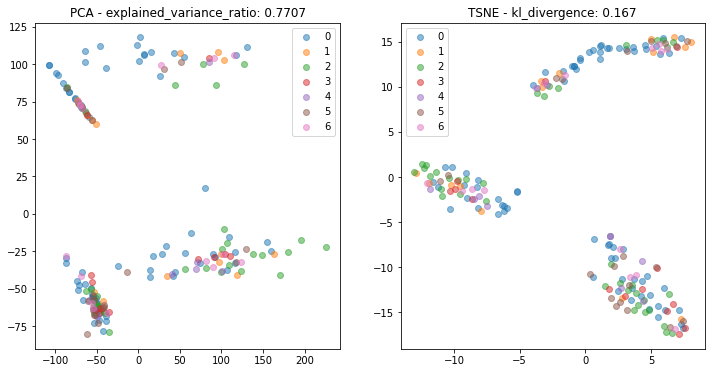

In [21]:
vis.plot_embeddings(x_train_encoded, y_train)

# Dealing with the imbalance

In [22]:
print('Original train dataset  classes distribution:', Counter(y_train))

sm = SMOTE(random_state=42, k_neighbors=5)
x_train_encoded, y_train = sm.fit_resample(x_train_encoded, y_train)
# ada = ADASYN(random_state=42, n_neighbors=5)
# x_train_encoded, y_train = ada.fit_resample(x_train_encoded, y_train)

print('Resampled train dataset classes distribution:', Counter(y_train))

Original train dataset  classes distribution: Counter({0: 76, 2: 38, 5: 20, 6: 16, 1: 15, 3: 14, 4: 8})
Resampled train dataset classes distribution: Counter({2: 76, 0: 76, 5: 76, 4: 76, 1: 76, 3: 76, 6: 76})


In [23]:
print('Original test dataset classes distribution:', Counter(y_test))

Original test dataset classes distribution: Counter({0: 34, 2: 16, 6: 11, 3: 9, 5: 7, 4: 4, 1: 3})


# Plottting Embeddings (after re-balancing):

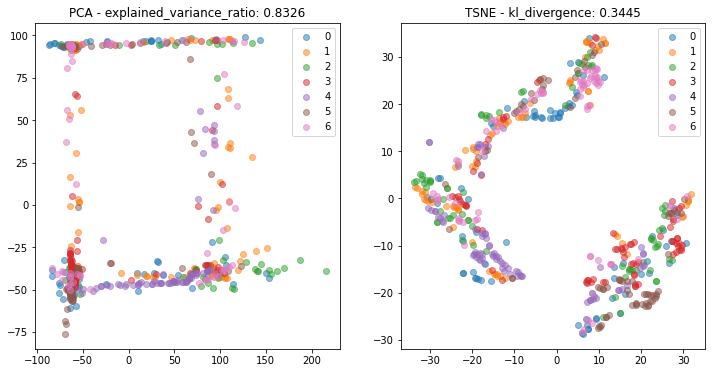

In [24]:
vis.plot_embeddings(x_train_encoded, y_train)

# Training a basic model

In [25]:
n_jobs = 4

In [26]:
# Random Forest:
param_grid = {'bootstrap': [False, True],
              'max_depth': [80, 90, 100, 110],
              'max_features': [2, 3],
              'min_samples_leaf': [3, 4, 5],
              'min_samples_split': [8, 10, 12],
              'n_estimators': [10, 50, 100, 200, 300, 500]}

rf_clf = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_grid, n_iter=50,
                            scoring='balanced_accuracy', n_jobs=n_jobs, verbose=1)
rf_clf.fit(x_train_encoded, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=50, n_jobs=4,
                   param_distributions={'bootstrap': [False, True],
                                        'max_depth': [80, 90, 100, 110],
                                        'max_features': [2, 3],
                                        'min_samples_leaf': [3, 4, 5],
                                        'min_samples_split': [8, 10, 12],
                                        'n_estimators': [10, 50, 100, 200, 300,
                                                         500]},
                   scoring='balanced_accuracy', verbose=1)

In [27]:
# Logistic Regression:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'penalty': ['l1', 'l2'],
              'max_iter': list(range(100,800,100)),
               'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
             }

lr_clf = RandomizedSearchCV(LogisticRegression(), param_distributions=param_grid, n_iter=50,
                            scoring='balanced_accuracy', n_jobs=n_jobs, verbose=1)
lr_clf.fit(x_train_encoded, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\users\weldl\miniconda3\envs\work\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.66059524 0.53464286 0.57940476 0.2202381  0.5775
        nan        nan 0.67738095 0.88035714 0.62083333 0.71690476
 0.25214286 0.82583333        nan        nan 0.52321429        nan
        nan        nan 0.8747619  0.89928571 0.61321429 0.41440476
 0.58130952        nan 0.69952381 0.8972619  0.22583333 0.65988095
        nan        nan        nan        nan        nan 0.66059524
 0.41452381 0.87059524        nan        nan 0.66440476 0.78916667
        nan        nan 0.4125     0.91214286 0.70380952 0.82583333
        nan 0.4952381 ]
  warnings.warn(


RandomizedSearchCV(estimator=LogisticRegression(), n_iter=50, n_jobs=4,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100,
                                              1000],
                                        'max_iter': [100, 200, 300, 400, 500,
                                                     600, 700],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   scoring='balanced_accuracy', verbose=1)

In [29]:
# KNN:
param_grid={'n_neighbors': np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
            'weights': ['uniform', 'distance'], 
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'metric': ['minkowski', 'euclidean', 'manhattan'],
           }

knn_clf = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_grid, n_iter=50,
                            scoring='balanced_accuracy', n_jobs=n_jobs, verbose=1)
knn_clf.fit(x_train_encoded, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(estimator=KNeighborsClassifier(), n_iter=50, n_jobs=4,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'metric': ['minkowski', 'euclidean',
                                                   'manhattan'],
                                        'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'weights': ['uniform', 'distance']},
                   scoring='balanced_accuracy', verbose=1)

In [30]:
# SVM:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'degree': [1, 2, 3, 4, 5],
             }

svm_clf = RandomizedSearchCV(SVC(), param_distributions=param_grid, n_iter=50,
                             scoring='balanced_accuracy', n_jobs=n_jobs, verbose=1)
svm_clf.fit(x_train_encoded, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(estimator=SVC(), n_iter=50, n_jobs=4,
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'degree': [1, 2, 3, 4, 5],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   scoring='balanced_accuracy', verbose=1)

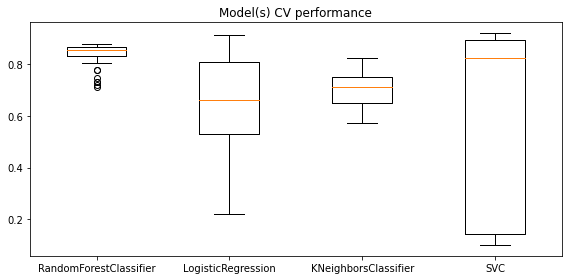

In [31]:
estimators_list = [rf_clf, lr_clf, knn_clf, svm_clf]
ev.plot_estimators_cvperf(estimators_list)

In [32]:
model = estimators_list[np.argmax([pd.DataFrame(m.cv_results_)['mean_test_score'].dropna().max() for m in estimators_list])].best_estimator_
model.fit(x_train_encoded, y_train)

SVC(C=100, degree=1, gamma=1, kernel='poly')

# Evaluating the model:

Classes evaluated: [1, 2, 3, 4, 5, 6, 7]
Correctly classified......: 32/84
Accuracy (simple) ........: 0.38
Balanced acc.  ...........: 0.26
Balanced acc. (adjusted)..: 0.13
Acc. norm (Recall avgs) ..: 0.26
Precision = tp / (tp + fp): [0.61 0.17 0.5  0.5  0.   0.   0.25] -> accuracy of positive predictions
Recall    = tp / (tp + fn): [0.56 0.33 0.5  0.22 0.   0.   0.18] -> sensibility (true positive rate)
F1 score .................: [0.58 0.22 0.5  0.31 0.   0.   0.21] -> harmonic mean


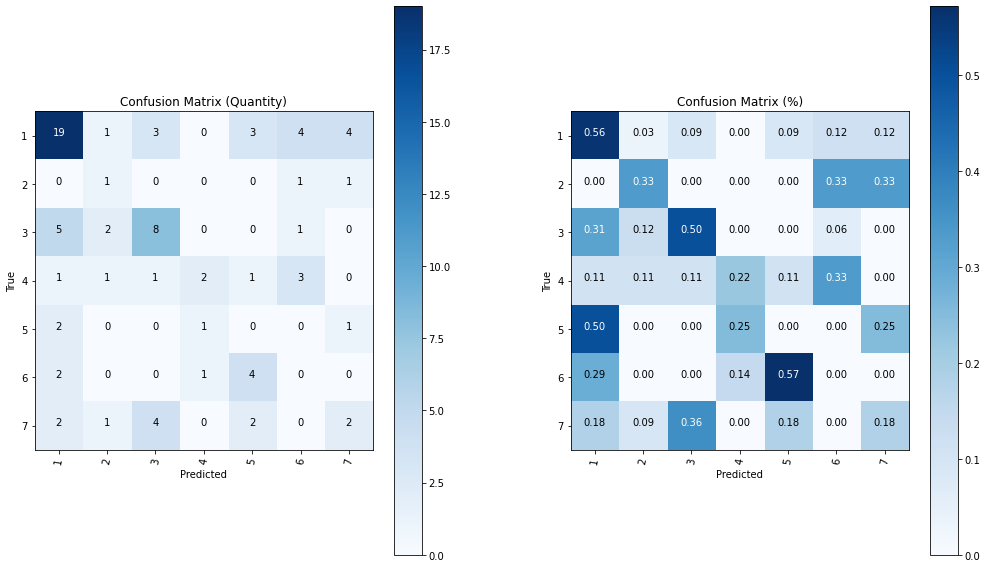

In [33]:
y_pred = model.predict(x_test_encoded)
test_metrics = ev.performance_measures(y_test, y_pred, class_names=TARGET_NAMES)

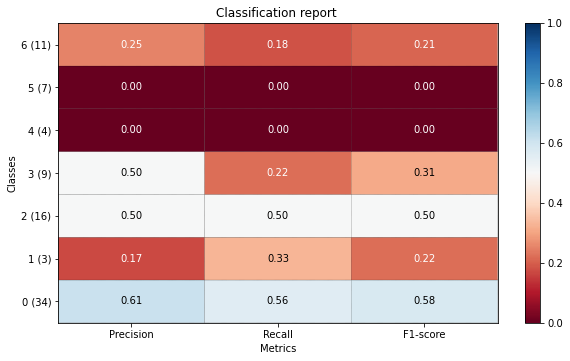

In [34]:
ev.plot_classification_report(y_test, y_pred)